In [27]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv('train.csv').drop(columns=['id'])
df_test = pd.read_csv('test.csv').drop(columns=['id'])
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB


In [30]:
df['Surname'].value_counts()

Surname
Hsia         2456
T'ien        2282
Hs?          1611
Maclean      1577
Kao          1577
             ... 
Topp            1
Blacklock       1
McDaniels       1
McMinn          1
Elkins          1
Name: count, Length: 2797, dtype: int64

In [31]:
lst = df['Surname'].value_counts().sort_values().reset_index()['Surname'].tolist()
dct = {}
for i in range(len(lst)):
    dct[lst[i]] = i 
df['Surname'] = df['Surname'].map(dct)

In [32]:
lst = df_test['Surname'].value_counts().sort_values().reset_index()['Surname'].tolist()
dct = {}
for i in range(len(lst)):
    dct[lst[i]] = i 
df_test['Surname'] = df_test['Surname'].map(dct)

In [33]:
def WoE_v2(data, feature_name, target_name):
    df = data.copy()
    
    woe_table = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})
    
    woe_table['Percentage events'] = woe_table['# of events'] / woe_table['# of events'].sum()
    woe_table['Percentage non-events'] = woe_table['# of non-events'] / woe_table['# of non-events'].sum()
    
    woe_table['WoE'] = np.log(woe_table['Percentage events'] / woe_table['Percentage non-events'])
    
    woe_table['Total Observations'] = woe_table['# of events'] + woe_table['# of non-events']
    woe_table['Percent of Observations'] = (woe_table['Total Observations'] / woe_table['Total Observations'].sum() * 100).round(3)

    return woe_table.reset_index()

In [34]:
df['Age_Cat'] = pd.qcut(df['Age'], q=6, labels=['a', 'b', 'c', 'd', 'e', 'f'])
df_test['Age_Cat'] = pd.qcut(df_test['Age'], q=6, labels=['a', 'b', 'c', 'd', 'e', 'f'])

In [35]:
df_woe = WoE_v2(df, 'Age_Cat', 'Exited')
df_woe

C:\Users\user\AppData\Local\Temp\ipykernel_11420\2746613937.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_table = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


Exited,Age_Cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,a,26483,2386,0.068326,0.203538,-1.091570,28869,17.493
1,b,29186,2612,0.074797,0.224313,-1.098258,31798,19.268
2,c,23727,3203,0.091721,0.182357,-0.687211,26930,16.318
3,d,20899,4287,0.122763,0.160622,-0.268799,25186,15.261
4,e,18625,9306,0.266487,0.143145,0.621470,27931,16.924
5,f,11193,13127,0.375906,0.086025,1.474698,24320,14.736


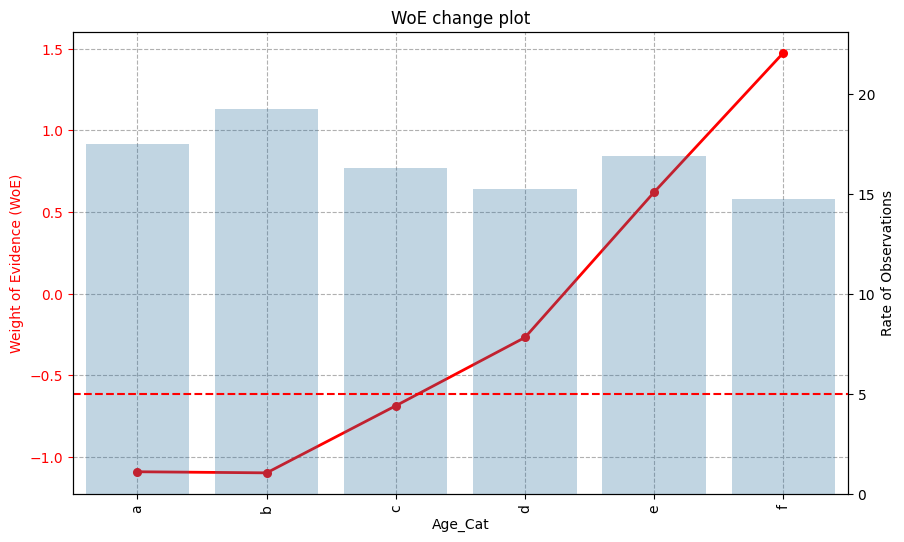

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 6)) 
ax2 = ax1.twinx()  

sns.pointplot(data=df_woe, x='Age_Cat', y='WoE', color='red', linewidth=2, ax=ax1)
ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
ax1.tick_params(axis='y', colors='red')
for label in ax1.get_xticklabels():
    label.set_rotation(90)
sns.barplot(data=df_woe, x='Age_Cat', y='Percent of Observations', alpha=0.3, ax=ax2)
ax2.set_ylabel('Rate of Observations')
ax2.set_ylim(0, df_woe['Percent of Observations'].max() * 1.2)  
ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.grid(visible=True, which='major', linestyle='--')
plt.title("WoE change plot")
plt.show()

In [37]:
df['EstimatedSalary_Cat'] = pd.qcut(df['EstimatedSalary'], q=7, labels=['a', 'b', 'c', 'd', 'e', 'f', 'g'])
df_test['EstimatedSalary_Cat'] = pd.qcut(df_test['EstimatedSalary'], q=7, labels=['a', 'b', 'c', 'd', 'e', 'f', 'g'])

In [38]:
df_woe = WoE_v2(df, 'EstimatedSalary_Cat', 'Exited')
df_woe

C:\Users\user\AppData\Local\Temp\ipykernel_11420\2746613937.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_table = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})


Exited,EstimatedSalary_Cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,a,18785,4793,0.137253,0.144375,-0.050587,23578,14.287
1,b,18669,4908,0.140546,0.143483,-0.020683,23577,14.286
2,c,18886,4698,0.134532,0.145151,-0.075969,23584,14.290
3,d,18697,4869,0.139429,0.143698,-0.030160,23566,14.279
4,e,18547,5030,0.144039,0.142545,0.010427,23577,14.286
5,f,18438,5148,0.147418,0.141708,0.039509,23586,14.292
6,g,18091,5475,0.156782,0.139041,0.120093,23566,14.279


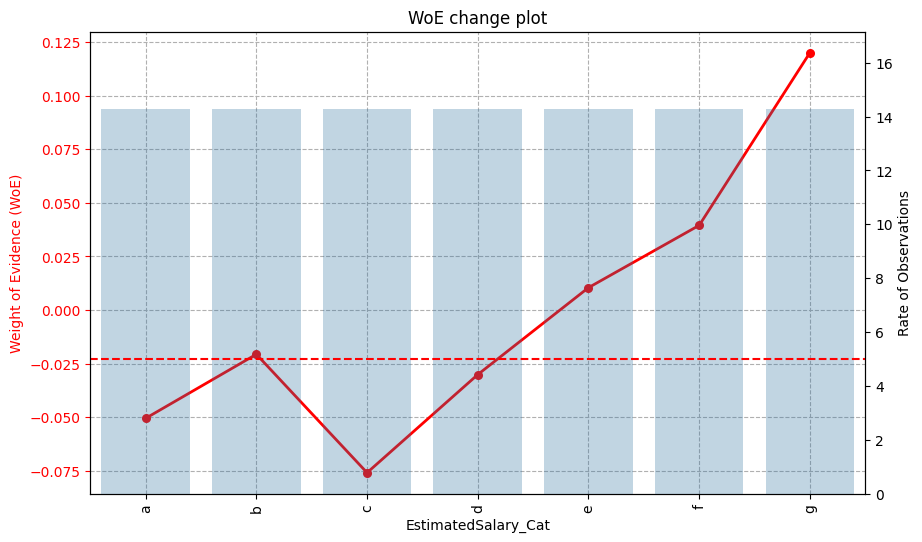

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 6)) 
ax2 = ax1.twinx()  

sns.pointplot(data=df_woe, x='EstimatedSalary_Cat', y='WoE', color='red', linewidth=2, ax=ax1)
ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
ax1.tick_params(axis='y', colors='red')
for label in ax1.get_xticklabels():
    label.set_rotation(90)
sns.barplot(data=df_woe, x='EstimatedSalary_Cat', y='Percent of Observations', alpha=0.3, ax=ax2)
ax2.set_ylabel('Rate of Observations')
ax2.set_ylim(0, df_woe['Percent of Observations'].max() * 1.2)  
ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.grid(visible=True, which='major', linestyle='--')
plt.title("WoE change plot")
plt.show()

In [40]:
df = pd.get_dummies(df, columns=['Geography', 'Gender', 'Age_Cat','EstimatedSalary_Cat'], dtype=int, drop_first=False)
df_test = pd.get_dummies(df_test, columns=['Geography', 'Gender', 'Age_Cat', 'EstimatedSalary_Cat'], dtype=int, drop_first=False)
df

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Age_Cat_d,Age_Cat_e,Age_Cat_f,EstimatedSalary_Cat_a,EstimatedSalary_Cat_b,EstimatedSalary_Cat_c,EstimatedSalary_Cat_d,EstimatedSalary_Cat_e,EstimatedSalary_Cat_f,EstimatedSalary_Cat_g
0,15674932,2638,668,33.0,3,0.00,2,1.0,0.0,181449.97,...,0,0,0,0,0,0,0,0,0,1
1,15749177,2660,627,33.0,1,0.00,2,1.0,1.0,49503.50,...,0,0,0,1,0,0,0,0,0,0
2,15694510,2788,678,40.0,10,0.00,2,1.0,0.0,184866.69,...,1,0,0,0,0,0,0,0,0,1
3,15741417,2792,581,34.0,2,148882.54,1,1.0,1.0,84560.88,...,0,0,0,0,0,1,0,0,0,0
4,15766172,2629,716,33.0,5,0.00,2,1.0,1.0,15068.83,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,2342,667,33.0,2,0.00,1,1.0,1.0,131834.75,...,0,0,0,0,0,0,0,1,0,0
165030,15665521,2664,792,35.0,3,0.00,1,0.0,0.0,131834.45,...,0,0,0,0,0,0,0,1,0,0
165031,15664752,2796,565,31.0,5,0.00,1,1.0,1.0,127429.56,...,0,0,0,0,0,0,1,0,0,0
165032,15689614,2775,554,30.0,7,161533.00,1,0.0,1.0,71173.03,...,0,0,0,0,1,0,0,0,0,0


In [41]:
# encoder = OrdinalEncoder()
# df['Surname'] = encoder.fit_transform(df[['Surname']])
# df['Geography'] = encoder.fit_transform(df[['Geography']])
# df['Gender'] = encoder.fit_transform(df[['Gender']])

# df_test['Surname'] = encoder.fit_transform(df_test[['Surname']])
# df_test['Geography'] = encoder.fit_transform(df_test[['Geography']])
# df_test['Gender'] = encoder.fit_transform(df_test[['Gender']])

# binary categoric => Gender, HasCrCard, IsActiveMember

In [48]:
df.corr()['Exited']

CustomerId              -0.009947
Surname                 -0.010415
CreditScore             -0.027383
Age                      0.340768
Tenure                  -0.019565
Balance                  0.129743
NumOfProducts           -0.214554
HasCrCard               -0.022141
IsActiveMember          -0.210237
EstimatedSalary          0.018827
Exited                   1.000000
Geography_France        -0.130797
Geography_Germany        0.211054
Geography_Spain         -0.051175
Gender_Female            0.146442
Gender_Male             -0.146442
Age_Cat_a               -0.145369
Age_Cat_b               -0.154838
Age_Cat_c               -0.100180
Age_Cat_d               -0.043000
Age_Cat_e                0.134354
Age_Cat_f                0.334020
EstimatedSalary_Cat_a   -0.008313
EstimatedSalary_Cat_b   -0.003428
EstimatedSalary_Cat_c   -0.012392
EstimatedSalary_Cat_d   -0.004984
EstimatedSalary_Cat_e    0.001744
EstimatedSalary_Cat_f    0.006665
EstimatedSalary_Cat_g    0.020712
Name: Exited, 

<Axes: >

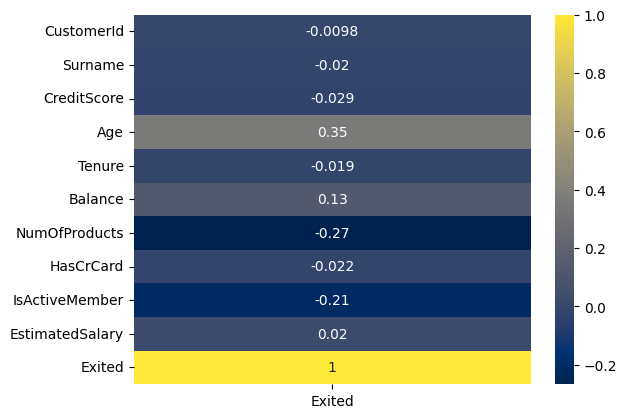

In [52]:
sns.heatmap(df[['CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 
                'IsActiveMember', 'EstimatedSalary', 'Exited']].corr(method="spearman")[["Exited"]], annot=True, cmap="cividis")

<Axes: >

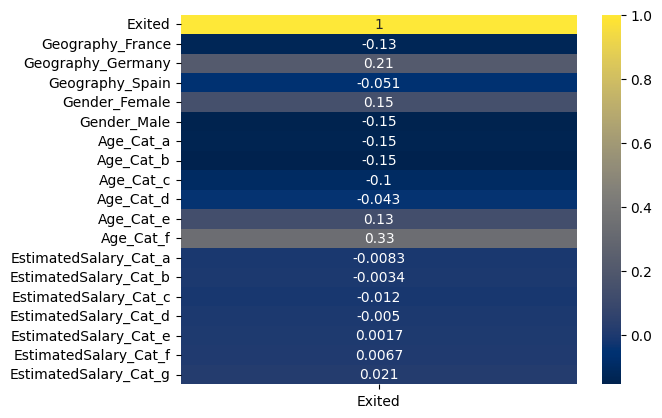

In [53]:
sns.heatmap(df[['Exited', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 
                'Age_Cat_a', 'Age_Cat_b', 'Age_Cat_c', 'Age_Cat_d', 'Age_Cat_e', 'Age_Cat_f', 'EstimatedSalary_Cat_a', 
                'EstimatedSalary_Cat_b', 'EstimatedSalary_Cat_c', 'EstimatedSalary_Cat_d', 'EstimatedSalary_Cat_e', 'EstimatedSalary_Cat_f', 
                'EstimatedSalary_Cat_g']].corr(method="kendall")[["Exited"]], annot=True, cmap="cividis")

In [42]:
X = df.drop(columns=['Exited', 'CustomerId'])
y = df['Exited']
df_test = df_test.drop(columns=['CustomerId'])
print(df_test.shape, X.shape)

poly = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000, C=0.1) 
pipeline = make_pipeline(scaler, poly, model)

pipeline.fit(X_train, y_train)

y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

roc_auc_pred = roc_auc_score(y_test, pipeline.predict(X_test))

roc_auc, roc_auc_pred

(110023, 27) (165034, 27)


(np.float64(0.8876610668244216), np.float64(0.7450938297957034))

In [43]:
y_pred_prob = pipeline.predict_proba(df_test)[:, 1]

In [44]:
sample = pd.read_csv('sample_submission.csv')
sample['Exited'] = y_pred_prob
sample

,id,Exited
0,165034,0.028517
1,165035,0.808707
2,165036,0.035943
3,165037,0.208684
4,165038,0.366679
...,...,...
110018,275052,0.025801
110019,275053,0.106113
110020,275054,0.017262
110021,275055,0.148295


In [45]:
# sample.to_csv('6-urinish.csv', index=False)

# git remote add origin https://github.com/ShukurulloNabiyev/Exam-4.git
# git branch -M main
# git push -u origin main